# King Country Real Estate Pricing

## Import and data overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import norm
import math
%matplotlib inline
pd.options.display.max_rows = 100
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import geopandas as gpd
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch


from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import cross_val_score

In [2]:
def col_rename(df, dict_rules, ip=True):
    ''' rename columns in data frame using a dictionary of rules  '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(dict_rules,dict):
        z = df.rename(columns = dict_rules, inplace=ip)
    else:
        raise TypeError
    return z
#
def print_unique(df,col):
    ''' gives a list of unique values in a field '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(df[col],pd.core.frame.Series):
        z = df[col].unique()
    else:
        raise TypeError
    return z
#

In [3]:
df = pd.read_csv('kc_house_data.csv') # read the housing data
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Check for nan values

In [5]:
df.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [39]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price_sqft       0
geometry         0
dtype: int64

Value counts for all columns

In [6]:
for col in df.columns:  
    print(col, '\n', pd.concat([df[col].value_counts(normalize=True).head(20), df[col].value_counts().head(20)],axis=1,keys=('fractional %','count')),
    '\n Min:', df[col].min(), '  Max:', df[col].max(), 
    'Unique Values:', df[col].nunique(),'\n')

id 
             fractional %  count
795000620       0.000139      3
8651510380      0.000093      2
2568300045      0.000093      2
9353300600      0.000093      2
4139480200      0.000093      2
1954420170      0.000093      2
6381500170      0.000093      2
7167000040      0.000093      2
9407110710      0.000093      2
1000102         0.000093      2
1781500435      0.000093      2
4139420590      0.000093      2
2621600015      0.000093      2
5083000375      0.000093      2
1788800630      0.000093      2
7230400400      0.000093      2
1231000510      0.000093      2
7520000520      0.000093      2
7657000540      0.000093      2
4364700600      0.000093      2 
 Min: 1000102   Max: 9900000190 Unique Values: 21436 

date 
                  fractional %  count
20140623T000000      0.006570    142
20140626T000000      0.006061    131
20140625T000000      0.006061    131
20140708T000000      0.005876    127
20150427T000000      0.005830    126
20150325T000000      0.005691    123
2

The label takes care of identifications so we can remove 'id'. We also chose to remove date sold and year renovated.

In [7]:
df.drop(labels=['id','date','yr_renovated'],axis=1,inplace=True) # drop

## Price variation across region

In [27]:
df['price_sqft'] = df['price']/df['sqft_living']

In [35]:
KCo_map = gpd.read_file('King_County_Political_Boundary_no_waterbodies__kingco_area.shp')
KCo_map.set_crs(epsg=4326, inplace=True)
#crs = {'init':'espc:4326'}
#crs=CRS("epsg:3857")
#KCo_map = KCo_map.to_crs(crs)
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, geometry = geometry)


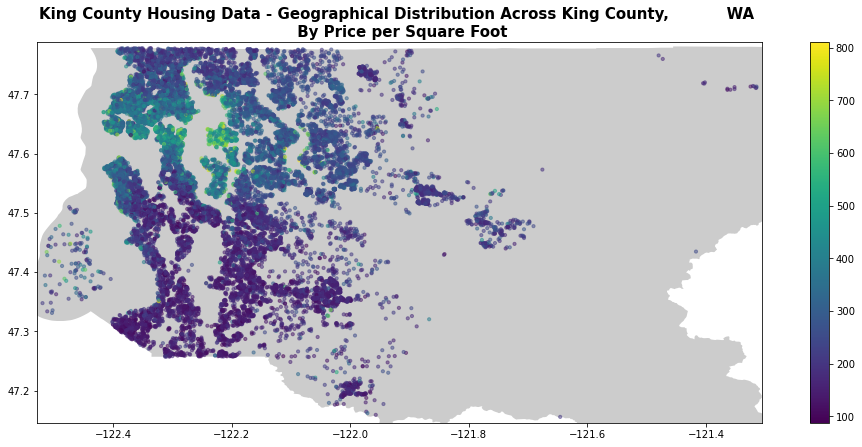

In [37]:
fig, ax = plt.subplots(figsize=(17,7))
KCo_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df.plot(column=df['price_sqft'],ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('King County Housing Data - Geographical Distribution Across King County, \
          WA \n By Price per Square Foot', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(df.long.min()-0.01,df.long.max()+0.01)
plt.ylim(df.lat.min()-0.01, df.lat.max()+0.01)

plt.show()

ValueError: Could not interpret input 'zipcode'

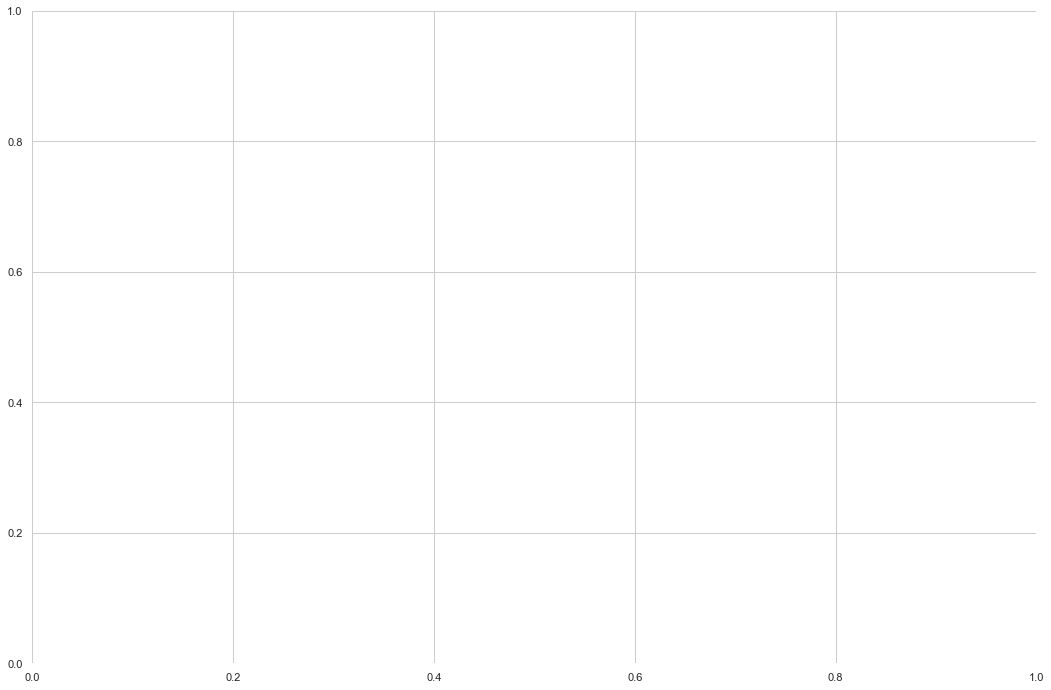

In [120]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.color_palette("bright")

f, ax = plt.subplots(figsize=(18, 12))
sns.despine(f, left=True, bottom=True)
sns.barplot(x="zipcode", y="price_sqft", data=df, ax=ax)
ax.set_title("Price Per Square Foot by Zip Code", fontsize=15,fontweight='bold')
ax.set_xlabel("Zip Code", fontsize=12,fontweight='bold')
ax.set_ylabel("Price per Square Foot of Living Space", fontsize=12,fontweight='bold')
plt.xticks(rotation=90)

plt.show()

In [63]:

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.761400e+04,17614.000000,17614.000000,17614.000000,1.761400e+04,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000
mean,5.819396e+05,3.523561,2.360211,2275.511638,1.589340e+04,1.578659,0.008289,0.263711,3.399341,7.903259,1940.201658,335.309981,1976.980186,98072.678608,47.559311,-122.200853,2104.903486,13375.940559
std,3.839505e+05,0.814398,0.608705,874.248157,4.163422e+04,0.550017,0.090668,0.810847,0.639589,1.112355,823.351256,464.766483,27.652410,52.195258,0.139528,0.140940,682.581346,28481.057541
min,1.070000e+05,0.000000,1.250000,590.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,550.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.500000e+05,3.000000,1.750000,1650.000000,5.070000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1330.000000,0.000000,1960.000000,98031.000000,47.462400,-122.317000,1600.000000,5106.250000
50%,4.900000e+05,3.000000,2.500000,2100.000000,7.769500e+03,2.000000,0.000000,0.000000,3.000000,8.000000,1730.000000,0.000000,1981.000000,98058.000000,47.575500,-122.207000,1970.000000,7725.000000
75%,6.890000e+05,4.000000,2.500000,2710.000000,1.120000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2390.000000,660.000000,2001.000000,98115.000000,47.676000,-122.111000,2490.000000,10400.000000
max,7.700000e+06,6.000000,8.000000,12050.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.319000,6210.000000,871200.000000


In [72]:
features = ['price', 'sqft_above','sqft_basement', 'sqft_lot', 'sqft_living15','sqft_lot15', 'sqft_living',
            'bedrooms','bathrooms','floors','waterfront',
            'view','condition','grade','yr_built',
            'zipcode']
['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'waterfront']

In [80]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
corrm=df[features].corr()

In [81]:
corrm['price'].sort_values()


yr_built        -0.041280
zipcode         -0.008328
condition        0.045679
sqft_lot15       0.081588
sqft_lot         0.091776
floors           0.184684
bedrooms         0.260382
sqft_basement    0.287114
waterfront       0.289013
view             0.404552
bathrooms        0.513055
sqft_living15    0.555312
sqft_above       0.575644
grade            0.657654
sqft_living      0.694766
price            1.000000
Name: price, dtype: float64

/var/folders/lj/my6r3k650wl54v5nz5r6x5cm0000gn/T/ipykernel_10137/2599800885.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df[features].corr(), dtype=np.bool)


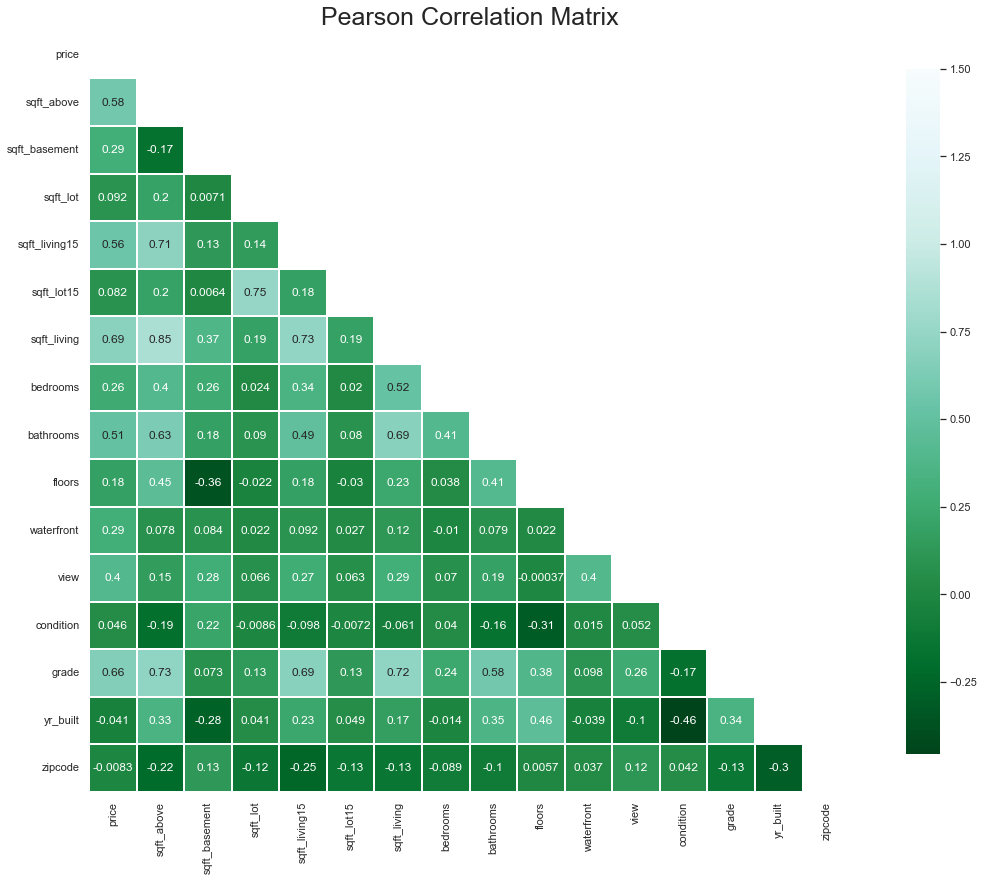

In [88]:


mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(20, 14))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.2,vmax=1.5,square=True, cmap="BuGn_r",
            linecolor='w',annot=True,annot_kws={"size":12},mask=mask,cbar_kws={"shrink": .9});

 - sqft_living and sqft_above display a multicolinearity, having a Pearson correlation of 0.88. 
 - To a lesser extent, there was some multicollinearity between sqft_living and sqft_living15 (between the living space of the house in question and the 15 closest neighbors), as well as sqft_living and grade (0.77) and sqft_above and grade (0.76). With regard to the first relationship, sqft_living has a 0.70 correlation with the target variable, price, while sqft_above only has a 0.60 correlation; this suggests we should drop sqft_above. This may also remove the multicollinearity between sqft_above and grade. Considering the strength of the sqft_living variable, it would also make sense to drop sqft_living15. The grade variable has a strong correlation with price, so despite the collinearity with sqft_living, I'll leav it in for now. Finally, it just doesn't make logical sense to keep the neighbors' lot sizes if we're dropping their living space square footage; accordingly, we'll drop that variable (sqft_lot15), as well as the preceding three.

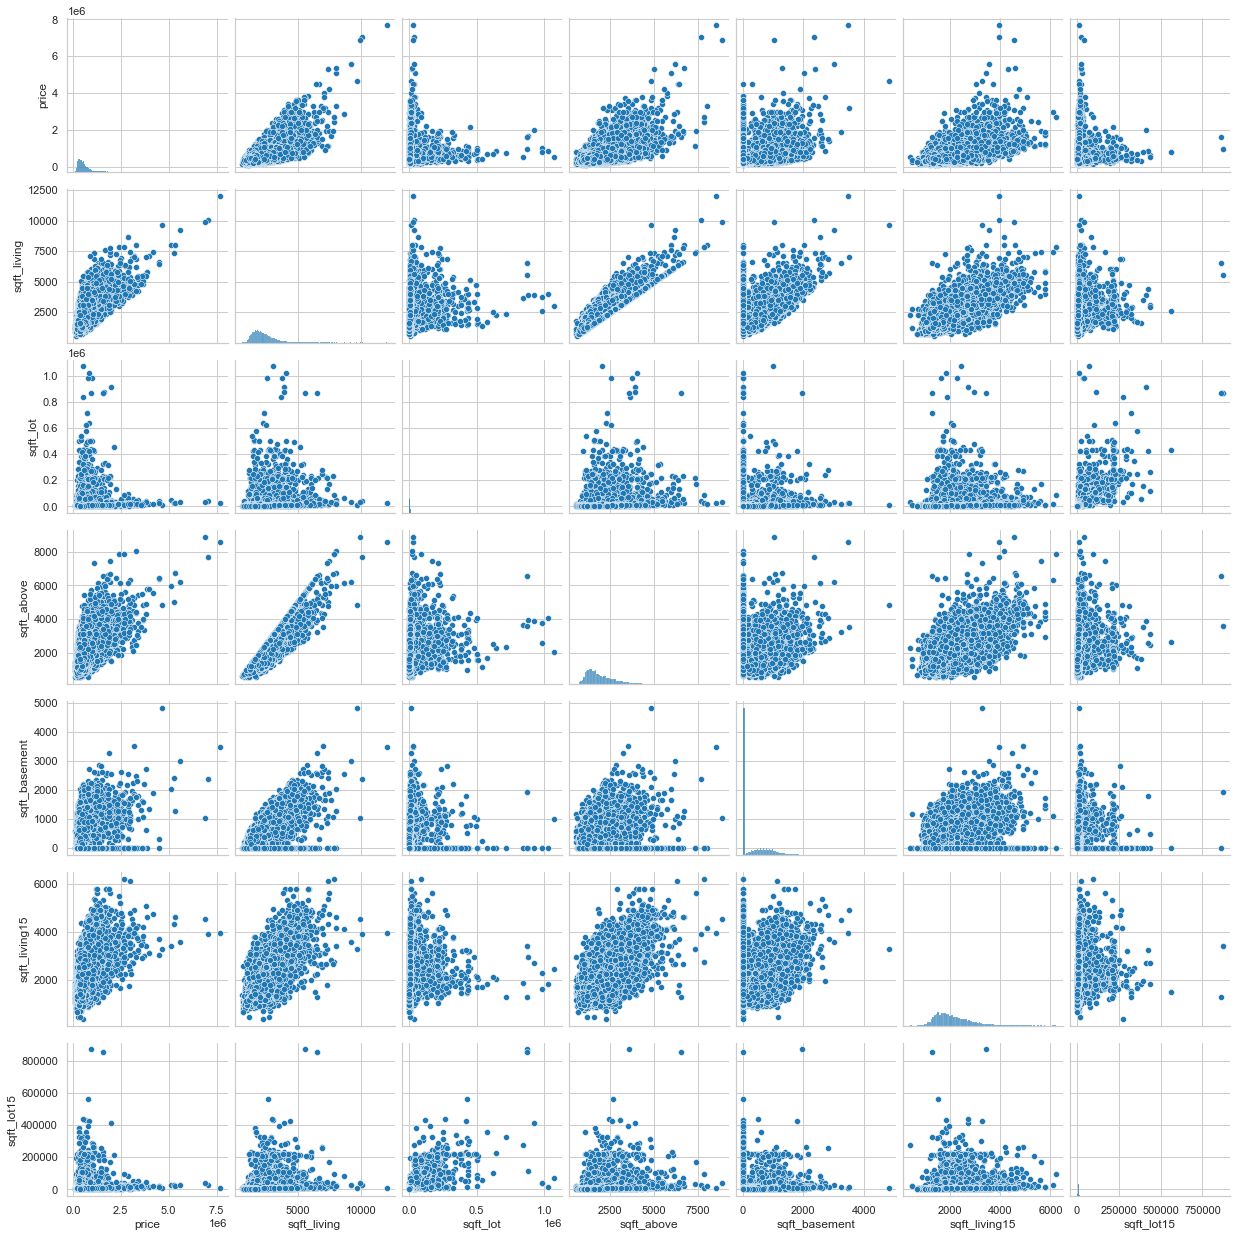

In [64]:
sns.pairplot(df[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                 'sqft_living15', 'sqft_lot15']])
plt.show()

sqft_lot and sqft_lot15 are not correlted linearly with price

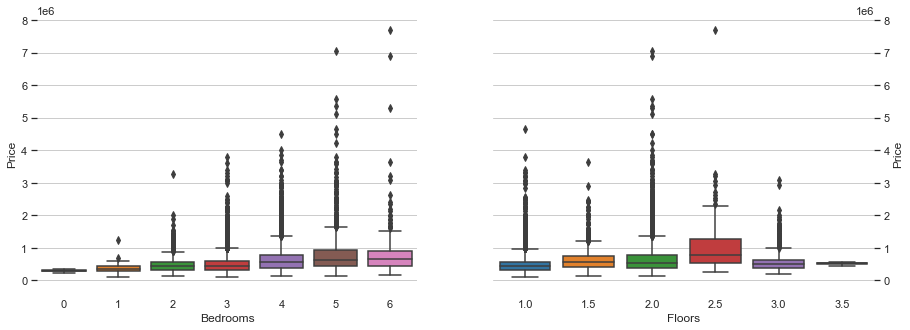

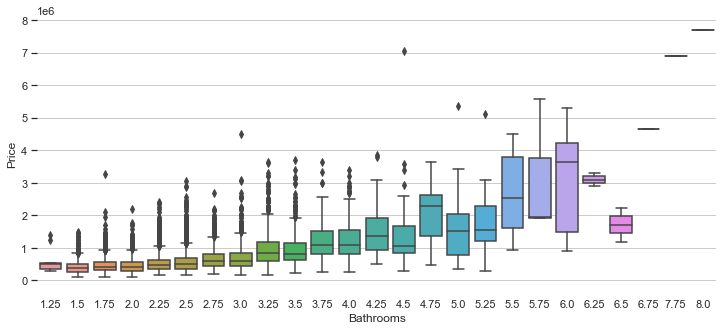

In [65]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['bedrooms'],y = df['price'], ax=axes[0])
sns.boxplot(x=df['floors'],y = df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms', ylabel='Price');

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

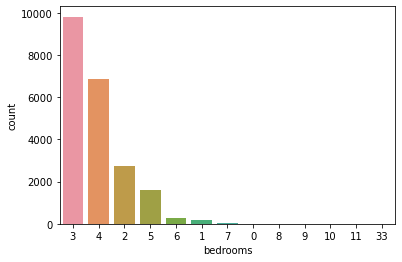

In [16]:
sns.countplot(df.bedrooms,order=df['bedrooms'].value_counts().index)

In [66]:
#limit dataset to properties with less than six bedrooms
df = df.loc[df['bedrooms'] < 7.0]
df = df.loc[df['bathrooms'] > 1.0]

(array([1.825e+04, 3.255e+03, 1.010e+02, 5.000e+00, 2.000e+00]),
 array([  290.,  2940.,  5590.,  8240., 10890., 13540.]),
 <BarContainer object of 5 artists>)

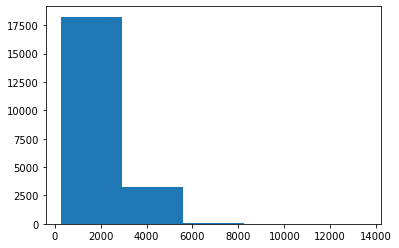

In [17]:
plt.hist('sqft_living',data=df,bins=5)

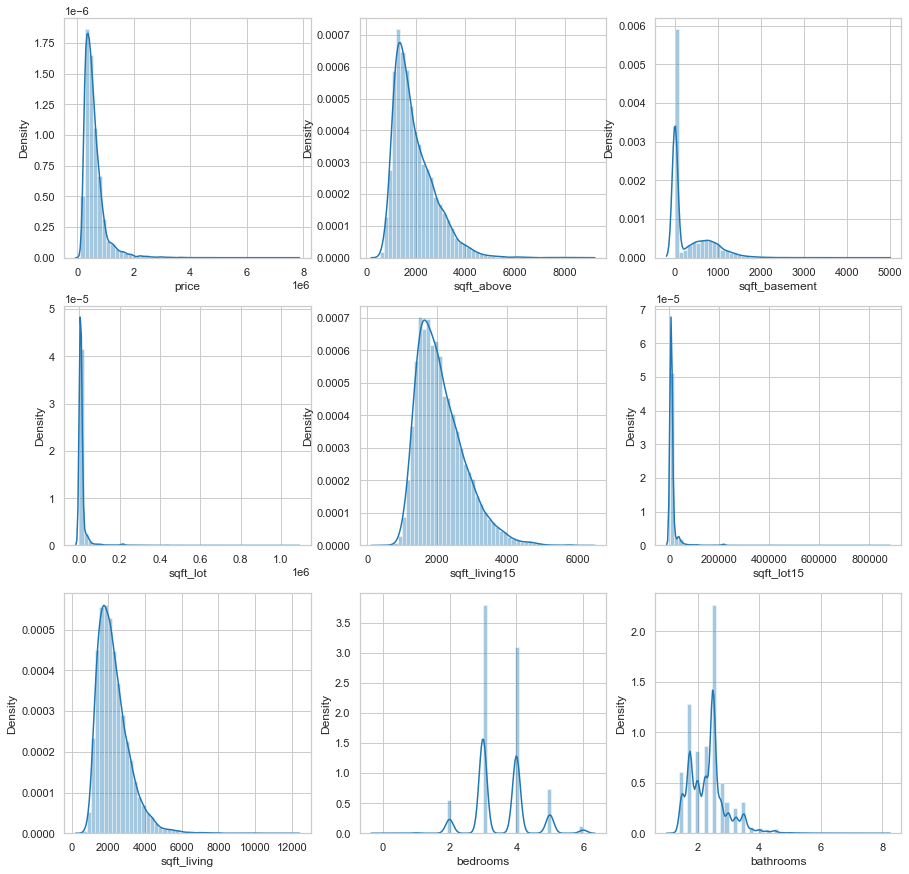

In [68]:
fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(15,15))

for i, ax in zip(range(9), axes.flat):
    sns.distplot(df[features[i]], ax=ax, kde=True)
plt.show()

In [20]:
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
#df = h_df[(h_df['price'] >= np.percentile(h_df['price'], 0.5)) & (h_df['price'] <= np.percentile(h_df['price'], 99.5)) & (h_df['lat'] >= np.percentile(h_df['lat'], 0.05)) &  (h_df['lat'] < np.percentile(h_df['lat'], 99.95)) &(h_df['long'] >= np.percentile(h_df['long'], 0.05)) &(h_df['long'] <= np.percentile(h_df['long'], 99.95))]

In [69]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503
5,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,98053,47.6561,-122.005,4760,101930
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21606,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,98136,47.5537,-122.398,2050,6200
21607,475000.0,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,98116,47.5773,-122.409,1330,1265
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,98103,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,98146,47.5107,-122.362,1830,7200


In [22]:
df['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [23]:
df[df['bathrooms']==0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
1149,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
3119,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
5832,280000.0,1,0.0,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
6994,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
9773,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
10481,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
14423,139950.0,0,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [89]:
df = df.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis = 1)

In [90]:
df.info() #Ensure those columns were dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17614 entries, 1 to 21611
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17614 non-null  float64
 1   bedrooms       17614 non-null  int64  
 2   bathrooms      17614 non-null  float64
 3   sqft_living    17614 non-null  int64  
 4   sqft_lot       17614 non-null  int64  
 5   floors         17614 non-null  float64
 6   waterfront     17614 non-null  int64  
 7   view           17614 non-null  int64  
 8   condition      17614 non-null  int64  
 9   grade          17614 non-null  int64  
 10  sqft_basement  17614 non-null  int64  
 11  yr_built       17614 non-null  int64  
 12  zipcode        17614 non-null  int64  
 13  lat            17614 non-null  float64
 14  long           17614 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 2.2 MB


There is a relatively normal distribution of price up to approximately $600,000. To keep the model as simple as possible, and because our approach is generally more aimed at middle to upper-middle-class homes, I think it would make sense to limit the model to include data from sales above 200,000 and below 600,000.

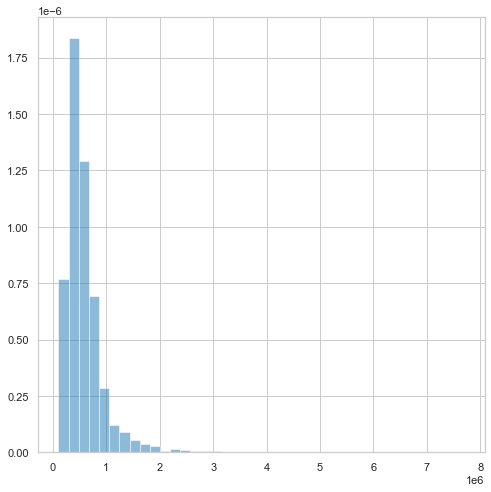

In [92]:
#Repeat histogram on price: 
price_hist = plt.figure(num=1, figsize=(8,8))
ax = price_hist.add_subplot(111)
ax.hist(df['price'], bins = 40, density = True, alpha = 0.5)
plt.show()


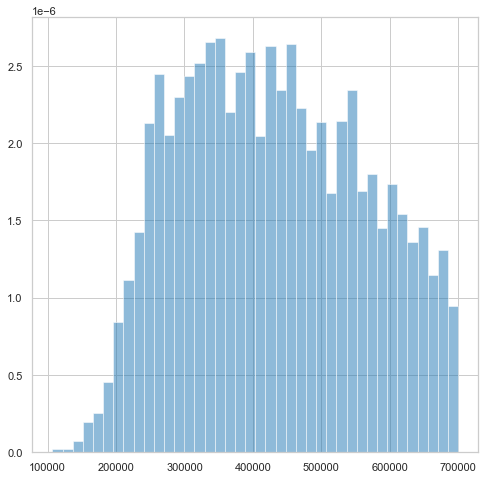

In [95]:
df = df.loc[df['price'] > 100000]
df = df.loc[df['price'] < 700000]
df.describe() 
#Repeat histogram on price: 
price_hist = plt.figure(num=1, figsize=(8,8))
ax = price_hist.add_subplot(111)
ax.hist(df['price'], bins = 40, density = True, alpha = 0.5)
plt.show()


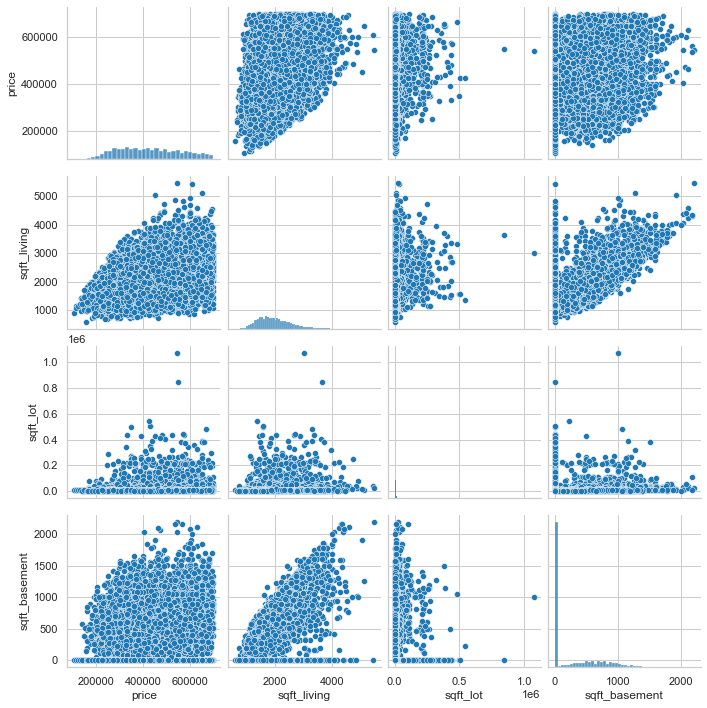

In [96]:
sns.pairplot(df[['price', 'sqft_living', 'sqft_lot', 'sqft_basement']])
plt.show()

In [97]:
df['log_sqft_lot'] = df['sqft_lot'].copy()
df['log_sqft_lot'] = df['log_sqft_lot'].map(lambda x: np.log(x))

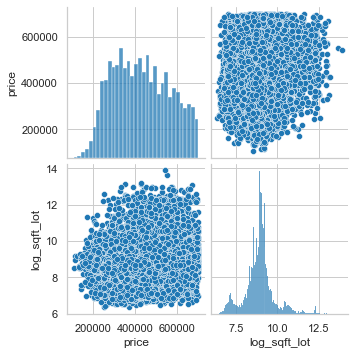

In [100]:
sns.pairplot(df[['price', 'log_sqft_lot']])
plt.show()

In [101]:


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df[['price', 'bedrooms', 'sqft_living', 'log_sqft_lot', 'floors',
       'condition', 'sqft_basement', 'yr_built', 'waterfront']].corr()



,price,bedrooms,sqft_living,log_sqft_lot,floors,condition,sqft_basement,yr_built,waterfront
price,1.000000,0.133502,0.409363,0.056765,0.145751,0.034316,0.157454,-0.049695,0.031799
bedrooms,0.133502,1.000000,0.529184,0.212581,-0.037094,0.050744,0.245127,-0.035417,-0.040071
sqft_living,0.409363,0.529184,1.000000,0.351321,0.137713,-0.060401,0.319216,0.160286,0.006966
log_sqft_lot,0.056765,0.212581,0.351321,1.000000,-0.384074,0.142238,0.109239,-0.181518,0.048603
floors,0.145751,-0.037094,0.137713,-0.384074,1.000000,-0.331192,-0.441731,0.531200,-0.000046
condition,0.034316,0.050744,-0.060401,0.142238,-0.331192,1.000000,0.207442,-0.436529,0.008738
sqft_basement,0.157454,0.245127,0.319216,0.109239,-0.441731,0.207442,1.000000,-0.307474,0.004696
yr_built,-0.049695,-0.035417,0.160286,-0.181518,0.531200,-0.436529,-0.307474,1.000000,-0.051216
waterfront,0.031799,-0.040071,0.006966,0.048603,-0.000046,0.008738,0.004696,-0.051216,1.000000


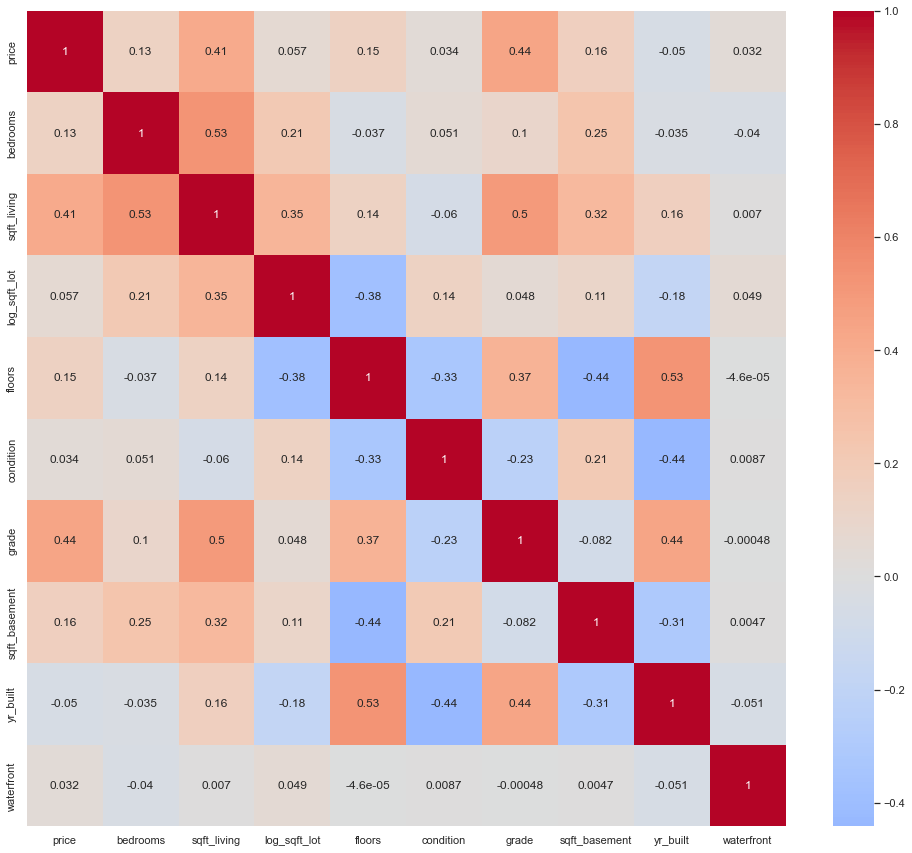

In [103]:
plt.subplots(figsize=(17,15))
sns.heatmap(df[['price', 'bedrooms', 'sqft_living', 'log_sqft_lot', 'floors',
       'condition', 'grade', 'sqft_basement', 'yr_built', 'waterfront']].corr(), 
        center=0,annot=True, cmap='coolwarm')
plt.show()

In [107]:
zipcode_dummies = pd.get_dummies(df['zipcode'], prefix='zip', drop_first=True)

df = bdf.drop(['zipcode'], axis=1)
df = pd.concat([df, zipcode_dummies], axis=1)


KeyError: 'zipcode'

In [112]:
df.drop(columns = ['lat', 'long'], inplace = True)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,log_sqft_lot,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,8.887653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,8.517193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,8.997147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,0,1995,8.827468,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,0,1963,9.181015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21605,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,0,2014,8.703341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21607,475000.0,3,2.50,1310,1294,2.0,0,0,3,8,130,2008,7.165493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,0,2009,7.030857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,0,2014,8.667852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [114]:
Y = df.price
features = df.drop(['price'], axis = 1)


In [119]:
formula = 'Y ~ bedrooms + bathrooms + sqft_living + floors + condition + grade + view \
            + sqft_basement + yr_built + waterfront + log_sqft_lot + zip_98002 \
            + zip_98003 + zip_98004 + zip_98005 + zip_98006 + zip_98007 + zip_98008 \
            + zip_98010 + zip_98011 + zip_98014 + zip_98019 + zip_98022 + zip_98023 \
            + zip_98024 + zip_98027 + zip_98028 + zip_98029 + zip_98030 + zip_98031 \
            + zip_98032 + zip_98033 + zip_98034 + zip_98038  + zip_98040 \
            + zip_98042 + zip_98045 + zip_98052 + zip_98053 + zip_98055 + zip_98056 \
            + zip_98058 + zip_98059 + zip_98065 + zip_98070 + zip_98072 + zip_98074 \
            + zip_98075 + zip_98077 + zip_98092 + zip_98102 + zip_98103 + zip_98105 \
            + zip_98106 + zip_98107 + zip_98108 + zip_98109 + zip_98112 + zip_98115 \
            + zip_98116 + zip_98117 + zip_98118 + zip_98119 + zip_98122 + zip_98125 \
            + zip_98126 + zip_98133 + zip_98136 + zip_98144 + zip_98146 + zip_98148 \
            + zip_98155 + zip_98166 + zip_98168 + zip_98177 + zip_98178 + zip_98188 \
            + zip_98198 + zip_98199'
model = ols(formula = formula, data = features).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     596.3
Date:                Tue, 28 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:57:57   Log-Likelihood:            -1.6663e+05
No. Observations:               13369   AIC:                         3.334e+05
Df Residuals:                   13289   BIC:                         3.340e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.812e+05   6.94e+04     -4.054      0.000   -4.17e+05   -1.45e+05
bedrooms      -2941.1428    871.492     -3.375      0.001   -4649.392   -1232.894
bathrooms       1.46e+04   1555.152      9.386      0.000    1.15e+04    1.76e+04
sqft_living      88.3687      1.663     53.153      0.000      85.110      91.628
floors        -9040.1917   1623.116     -5.570      0.000   -1.22e+04   -5858.654
condition      1.714e+04   1007.298     17.020      0.000    1.52e+04    1.91e+04
grade          3.684e+04    977.839     37.673      0.000    3.49e+04    3.88e+04
view           2.131e+04   1126.199     18.926      0.000    1.91e+04    2.35e+04
sqft_basement   -31.5956      1.961    -16.112      0.000     -35.439     -27.752
yr_built        -73.8305     34.329     -2.151      0.032    -141.121      -6.540
waterfront     6.514e+04   1.54e+04      4.238      0.000     3.5e+04    9.53e+04
log_sqft_lot   2.262e+04    927.970     24.377      0.000    2.08e+04    2.44e+04
zip_98002     -1045.6253   6440.014     -0.162      0.871   -1.37e+04    1.16e+04
zip_98003      1062.5757   5514.395      0.193      0.847   -9746.425    1.19e+04
zip_98004      3.466e+05   1.42e+04     24.385      0.000    3.19e+05    3.74e+05
zip_98005      2.882e+05   9119.300     31.601      0.000     2.7e+05    3.06e+05
zip_98006      2.305e+05   6008.148     38.359      0.000    2.19e+05    2.42e+05
zip_98007      2.348e+05   7668.868     30.616      0.000     2.2e+05     2.5e+05
zip_98008      2.415e+05   5787.674     41.719      0.000     2.3e+05    2.53e+05
zip_98010      6.528e+04   8445.392      7.729      0.000    4.87e+04    8.18e+04
zip_98011      1.622e+05   6012.552     26.976      0.000     1.5e+05    1.74e+05
zip_98014      9.225e+04   7892.728     11.688      0.000    7.68e+04    1.08e+05
zip_98019      1.096e+05   6053.409     18.099      0.000    9.77e+04    1.21e+05
zip_98022       453.1013   6024.449      0.075      0.940   -1.14e+04    1.23e+04
zip_98023      -1.54e+04   4776.341     -3.224      0.001   -2.48e+04   -6037.232
zip_98024      1.301e+05   1.05e+04     12.345      0.000    1.09e+05    1.51e+05
zip_98027      1.911e+05   5272.084     36.246      0.000    1.81e+05    2.01e+05
zip_98028      1.495e+05   5480.039     27.283      0.000    1.39e+05     1.6e+05
zip_98029      2.371e+05   5497.437     43.122      0.000    2.26e+05    2.48e+05
zip_98030      1.048e+04   5514.493      1.901      0.057    -325.969    2.13e+04
zip_98031      1.508e+04   5399.728      2.793      0.005    4496.107    2.57e+04
zip_98032     -1.553e+04   7752.408     -2.003      0.045   -3.07e+04    -334.656
zip_98033      2.683e+05   5911.958     45.381      0.000    2.57e+05     2.8e+05
zip_98034      1.828e+05   4802.872     38.068      0.000    1.73e+05    1.92e+05
zip_98038      5.167e+04   4531.804     11.402   